In [1]:
import pandas as pd
from minio import Minio
from io import BytesIO
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

# Load data inference from MinIO

In [2]:
env_path = os.path.join("..", ".env")
load_dotenv(env_path)

# Create MinIO client environment
client = Minio(
    f"{os.getenv('minio_host')}:{os.getenv('minio_port')}",
    access_key=os.getenv("access_key"),
    secret_key=os.getenv("secret_key"),
    secure=False
)

In [3]:
# Load from gold bucket
def load_from_minio(bucket_name: str) -> pd.DataFrame:
    objects = list(client.list_objects(bucket_name))

    if not objects:
        print(f"No objects found in bucket '{bucket_name}'.")
        return None
    
    # Get latest file
    latest = sorted(objects, key=lambda x: x.last_modified, reverse=True)[0]

    # Read data
    response = client.get_object(bucket_name, latest.object_name)
    df = pd.read_parquet(BytesIO(response.read()))

    # Close response
    response.close()
    response.release_conn()

    print(f"loaded {latest.object_name} from bucket '{bucket_name}'")
    return df

In [4]:
df = load_from_minio("gold")
df.head(10)

MaxRetryError: HTTPConnectionPool(host='localhost', port=9000): Max retries exceeded with url: /gold?location= (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1340a4190>: Failed to establish a new connection: [Errno 61] Connection refused'))

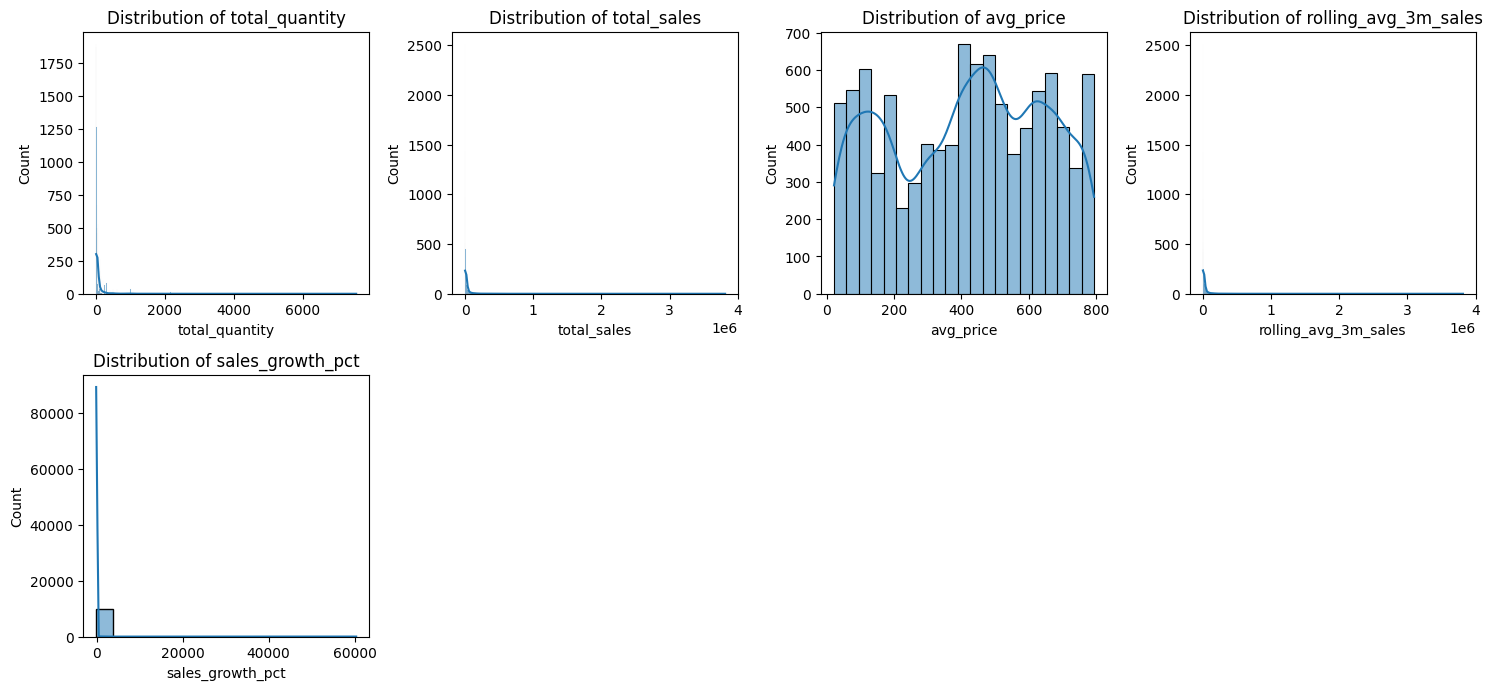

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

nums_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != 'year']
plt.figure(figsize=(15, 10))
for i, col in enumerate(nums_cols, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
# Visualize distributions of numerical columns
plt.show()

# Feature Engineering

In [ ]:
pd.DataFrame(df[nums_cols])

,total_quantity,total_sales,avg_price,rolling_avg_3m_sales,sales_growth_pct
0,9.0,315.0,35.0,315.0,0.0
1,10.0,4380.0,438.0,4380.0,0.0
2,10.0,5200.0,520.0,5200.0,0.0
3,5.0,645.0,129.0,645.0,0.0
4,48.0,1680.0,35.0,1680.0,0.0
...,...,...,...,...,...
9981,4.0,2196.0,549.0,2196.0,0.0
9982,6.0,786.0,131.0,786.0,0.0
9983,10.0,330.0,33.0,330.0,0.0
9984,3.0,123.0,41.0,123.0,0.0


In [ ]:
load_from_minio("silver")

loaded pharmacy_sales_20260105_115913_4.parquet from bucket 'silver'


,distributor,customer_name,city,country,latitude,longitude,channel,sub_channel,product_name,product_class,quantity,price,sales,month,year,sales_rep_name,manager,sales_team
0,Graham and Sons,Koss Ltd Pharmaceutical Limited,Lwówek Śląski,Poland,51.1167,15.5833,Hospital,Private,Choriogestrel,Antiseptics,120.0,347.0,41640.0,June,2018,Alan Ray,James Goodwill,Alfa
1,Graham and Sons,"Beahan, Littel and Ondricka Pharmacy",Łęczyca,Poland,52.0583,19.2000,Pharmacy,Institution,Exotropin Empizine,Mood Stabilizers,150.0,785.0,117750.0,June,2018,Alan Ray,James Goodwill,Alfa
2,Graham and Sons,Streich PLC Pharmaceutical Limited,Przemyśl,Poland,49.7850,22.7673,Pharmacy,Institution,Choriotrisin,Antibiotics,700.0,591.0,413700.0,June,2018,Abigail Thompson,Tracy Banks,Bravo
3,Graham and Sons,"Buckridge, Dach and Carroll Pharmaceutical Lim...",Luboń,Poland,52.3333,16.8833,Hospital,Private,Afaxacin,Analgesics,2.0,60.0,120.0,June,2018,Erica Jones,James Goodwill,Alfa
4,Graham and Sons,"Balistreri, Torp and Gulgowski Pharmacy",Chełmża,Poland,53.2000,18.6000,Hospital,Private,Abilovir Aprotasol,Antipiretics,12.0,269.0,3228.0,June,2018,Erica Jones,James Goodwill,Alfa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Smith Inc,Herman-Koss Pharm,Lubsko,Poland,51.7877,14.9724,Hospital,Private,Afluferon Entrarenone,Antimalarial,10.0,104.0,1040.0,July,2018,Erica Jones,James Goodwill,Alfa
996,Smith Inc,Bosco-Marquardt Pharm,Lębork,Poland,54.5500,17.7500,Hospital,Private,Interfestar,Antibiotics,10.0,62.0,620.0,July,2018,Sheila Stones,Britanny Bold,Delta
997,Smith Inc,Hill Ltd,Gliwice,Poland,50.2976,18.6766,Pharmacy,Retail,Amlominphen Dexanovate,Analgesics,90.0,119.0,10710.0,July,2018,Alan Ray,James Goodwill,Alfa
998,Smith Inc,"Schowalter, Runolfsson and VonRueden Pharmaceu...",Grudziądz,Poland,53.4925,18.7761,Pharmacy,Retail,Thionide,Analgesics,10.0,113.0,1130.0,July,2018,Sheila Stones,Britanny Bold,Delta
